In [3]:
import sacc
import numpy as np
from matplotlib import pyplot as plt

from mutually_closest import PairsMutuallyClosest

s = sacc.Sacc.load_fits('../data/cls_cov.fits')

# N(z)

In [5]:
# Load catalog
pairs = {}
cname = 'CMASS'
# cat1 = '../../../data/galaxy_DR12v5_CMASS_North.fits.gz'
# cat2 = '../../../data/galaxy_DR12v5_CMASS_South.fits.gz'
cat1 = '/mnt/extraspace/damonge/Datasets/BOSS/galaxy_DR12v5_CMASS_North.fits.gz'
cat2 = '/mnt/extraspace/damonge/Datasets/BOSS/galaxy_DR12v5_CMASS_South.fits.gz'
fname = [cat1, cat2]
# Find isolated pairs within a 1 Mpc radius 
radius_cut = 1 
pairs[cname] = {}
pairs[cname]['mclosest'] = PairsMutuallyClosest(fname, radius_cut)
# pairs[cname]['isolated'] = PairsIsolated(fname, radius_cut)
# pairs[cname]['rel_isolated'] = PairsRelativeIsolated(fname, radius_cut)

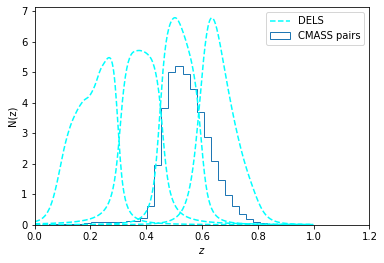

In [6]:
for trn, tr in s.tracers.items():
    if 'DELS' in trn:
        plt.plot(tr.z, tr.nz, ls='--', c='cyan', label='DELS' if 'DELS__0' == trn else '')

cname = 'CMASS'
# Plot histogram of their redshifts and the mean redshift
z = pairs[cname]['mclosest'].cat['Z']
z_mean = np.mean(z)
plt.hist(z, bins=np.linspace(z.min(), 2.5, 100),
         label=f'CMASS pairs', 
         histtype='step', density=True, rwidth=100);

plt.xlim(0, 1.2)
plt.xlabel(r'$z$')
plt.ylabel('N(z)')
plt.legend()    
plt.show()
plt.close()

# Footprint

In [65]:
import sys
sys.path.append('../../xCell/')
import xcell
import healpy as hp
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False


def scale_bin_map(mask, c):
    m = mask.copy()
    goodpix = mask != 0
    m[goodpix] = c
    return m

def get_fsky(m_a1, m_a2):
    fsky = np.mean(((m_a1 > 0) & (m_a2 > 0)))
    return fsky


nside = 128
coords = 'C'

DELS = xcell.mappers.MapperDELS({
    'data_catalogs': [
        '/mnt/extraspace/damonge/Datasets/DELS/Legacy_Survey_BASS-MZLS_galaxies-selection.fits',
        '/mnt/extraspace/damonge/Datasets/DELS/Legacy_Survey_DECALS_galaxies-selection.fits'],
    'zbin': 0,
    'binary_mask': '/mnt/extraspace/damonge/Datasets/DELS/Legacy_footprint_final_mask_cut_decm36.fits',
    'nl_analytic': True,
    'completeness_map': '/mnt/extraspace/damonge/Datasets/DELS/Legacy_footprint_completeness_mask_128.fits',
    'star_map': '/mnt/extraspace/damonge/Datasets/DELS/allwise_total_rot_1024.fits',
                                      'coords': coords,
    'nside': nside,
   }
)

True
True
True


0.0 180.0 -180.0 180.0


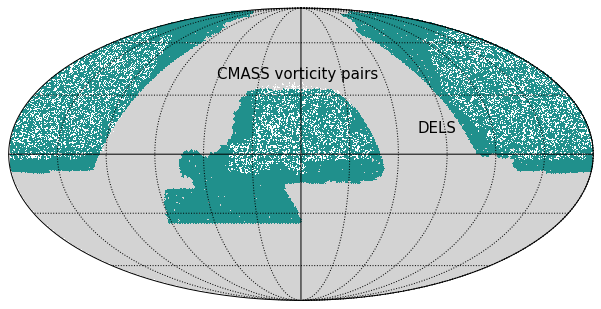

In [100]:
# For the transaprency to work you need to comment healpy/projaxes.py#L189
# See https://github.com/healpy/healpy/issues/765
vort = scale_bin_map(pairs[cname]['mclosest'].get_number_counts_map(nside), -1)
dels0mask = scale_bin_map(DELS.get_mask(), 1)

vortalpha = scale_bin_map(vort, 1)

dels0mask[dels0mask == 0] = hp.UNSEEN
hp.mollview(dels0mask, badcolor='lightgray', cbar=False, title='')
hp.mollview(vort, reuse_axes=True, alpha=vortalpha, cmap='Greys', cbar=False, title='')
hp.graticule()

plt.text(-0.02, 0.52, 'CMASS vorticity pairs', fontsize=15, color='black', horizontalalignment='center')
plt.text(0.80, 0.15, 'DELS', fontsize=15, color='black', horizontalalignment='left')

# plt.savefig('CMASS_DELS_footprint.pdf')
plt.show()
plt.close()

# $C_\ell$

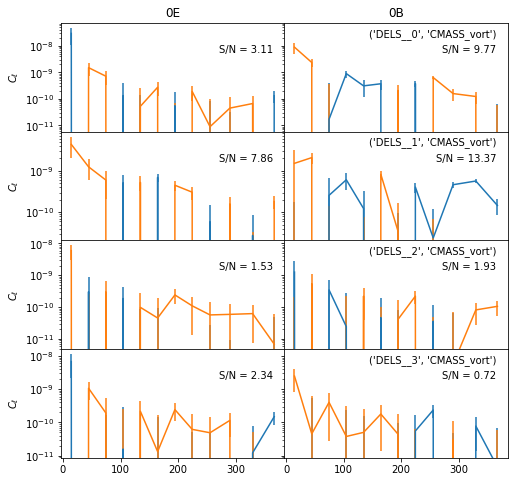

In [44]:
f, axs = plt.subplots(4, 2, sharex=True, sharey='row', figsize=(8, 8),
                      gridspec_kw={'hspace': 0, 'wspace': 0})
for i, trs in enumerate(s.get_tracer_combinations()):
    if trs[0] == trs[1]:
        continue
    axs[i, 0].set_ylabel(f'$C_\ell$')
    axs[i, 1].text(0.95, 0.95, trs,
                   horizontalalignment='right',
                   verticalalignment='top',
                   transform=axs[i, 1].transAxes)

    for idt, dt in enumerate(['cl_0e', 'cl_0b']):
        ax = axs[i, idt]
        ell, cl, cov = s.get_ell_cl(dt, *trs, return_cov=True)
        
        chi2 = cl.dot(np.linalg.inv(cov).dot(cl))
        SN = np.sqrt(chi2 - cl.size)
        
        ax.text(0.95, 0.8, f'S/N = {SN:.2f}',
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes)
    
        err = np.sqrt(np.diag(cov))
        ax.errorbar(ell, cl, yerr=err)
        ax.errorbar(ell, -cl, yerr=err)
        ax.set_yscale('log')

axs[0, 0].set_title('0E')
axs[0, 1].set_title('0B')
axs[0, -1].set_xlabel(r'$\ell$')
plt.show()
plt.close()

/tmp/ipykernel_276647/2674432303.py:11: RuntimeWarning: invalid value encountered in sqrt
  SN = np.sqrt(chi2 - cl.size)


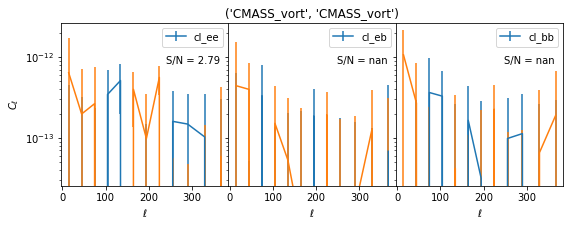

In [45]:
f, axs = plt.subplots(1, 3, sharex=True, sharey='row', figsize=(9, 3),
                      gridspec_kw={'hspace': 0, 'wspace': 0})

trs = ('CMASS_vort', 'CMASS_vort')
for idt, dt in enumerate(['cl_ee', 'cl_eb', 'cl_bb']):
    ax = axs[idt]
    ell, cl, cov = s.get_ell_cl(dt, *trs, return_cov=True)
    err = np.sqrt(np.diag(cov))

    chi2 = cl.dot(np.linalg.inv(cov).dot(cl))
    SN = np.sqrt(chi2 - cl.size)

    ax.text(0.95, 0.8, f'S/N = {SN:.2f}',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)
    
    
    ax.errorbar(ell, cl, yerr=err, label=dt)
    ax.errorbar(ell, -cl, yerr=err)
    ax.set_yscale('log')
    ax.set_xlabel('$\ell$')
    ax.legend(loc=0)
    
axs[1].set_title(f'{trs}')
axs[0].set_ylabel(r'$C_\ell$')
plt.show()
plt.close()